In [1]:
import numpy as np
import pickle
import sys
from typing import List
import torch
import os

In [2]:
participant_data_path = './EEG/number'
processed_data_path = './EEG/processed_data'
split_data_path = './EEG/split_data'

In [3]:
ps = os.listdir(participant_data_path)
participants=[]
for p in ps:
    p= p[:3]
    if p not in participants:
        participants.append(p)
        
participants= sorted(participants)
# participants, len(participants)

In [4]:
load_name=f"userfold_data_scaled_p_dictionary-number"
data_dir = "./EEG/split_data/standard_scaled"
try:
    raw_user_fold= pickle.load(open(os.path.join(data_dir, f"{load_name}.pkl"), "rb"))
except:
    print(f"pickle file does not exist. Use EEG-Preprocess.ipynb and EEG-Split.ipynb to save data setting.")
    sys.exit()

In [6]:
from utilities.userfold_framework import *
from Models.AR_EEG_models import *
import Models.model_func as Model_Func
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from torcheeg.models import EEGNet

from torch import nn
from Models.multi_models import *

DEVICE= torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

learning_rate = 0.00005
batch_size = 64
n_epochs = 300
transpose_channels=True
participants_dictionary=[]
# participants_online_dictionary=[]
participants_grads_dictionary={}
b_acc_list=[]
c0_acc_list=[]
c1_acc_list=[]

# EPOCH=[
    
# ]

for i in range(len(participants)):

    train_dataloader, val_dataloader, classes, input_dim, class_ratio= user_fold_load(i,
                                                                                      raw_user_fold,
                                                                                      participants,
                                                                                      batch_size=batch_size,
                                                                                      transpose_channels=transpose_channels)

    classifier= EEGNet(
        chunk_size=input_dim[1],
        num_electrodes=input_dim[0],
        num_classes=classes,
        kernel_1= 32,
        kernel_2=32,
        F1=8,
        F2=16,
        dropout=0.5
    ).to(DEVICE)
    
    
    criterion= torch.nn.CrossEntropyLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))
#     criterion = nn.NLLLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))
        
    saved_dir= "./EEG/saved_models/Userfold/run0"
    model = EEGNet_IE_EEG_Wrapper(DEVICE, classifier, input_dim[0]).to(DEVICE)
    optimizer = torch.optim.Adam(classifier.parameters(), lr = learning_rate)
#     optimizer= torch.optim.RMSprop(classifier.parameters(), lr=learning_rate)

    scheduler= torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)

    
#     train_func= eeg_grad_train
#     model.training_procedure(iteration=n_epochs,
#                                     train_dataloader=train_dataloader,
#                                      val_dataloader=val_dataloader,
#                                      print_cycle=2,
#                                      path=f"./dictionary/intermdiate_dicts",
#                                      loss_func=criterion,
#                                      optimiser=optimizer, #scheduler=scheduler,
#                                      train_func=train_func
#                                     )
#     if model.epoch == n_epochs+1:
#         EPOCH= n_epochs
#     else:
#         EPOCH= model.epoch
    
#     torch.save(model.state_dict(), 
#            os.path.join(
#                saved_dir, f"Userfold-{participants[i]}-EEGNet-Grad_EEG-e{EPOCH}.pt"
#            )
#     )

#     pickle.dump( model.return_IE_grad(), 
#                 open(f"{saved_dir}/Userfold-{participants[i]}-EEGNet-Grad_EEG-grad_all-e{EPOCH}.pkl", "wb") 
#                )    

# OR
    model.load_state_dict(
    torch.load(
        open(
            os.path.join(
                saved_dir, f"Userfold-{participants[i]}-EEGNet-Grad_EEG-e{n_epochs}.pt"
            ), "rb"
        )
              )
    )
    
    prediction, dictionary= model.prediction_procedure(val_dataloader, dict_flag=True)
    
    ys= np.concatenate([y.detach().cpu().numpy() for x, y in val_dataloader])
    
    c0_acc, c1_acc, b_acc= calculate_accuracy(ys, prediction)
    print("c0_acc", c0_acc, ", c1_acc", c1_acc, ", b_acc", b_acc)
    b_acc_list.append(b_acc)
    c0_acc_list.append(c0_acc)
    c1_acc_list.append(c1_acc)
    participants_dictionary.append(dictionary)
    

tmp=[]
for i, dictionary in enumerate(participants_dictionary):
    print(f"User {participants[i]} f1: {dictionary['weighted avg']['f1-score']} acc: {dictionary['accuracy']}")
    print(f" c0: {c0_acc_list[i]} c1: {c1_acc_list[i]} bacc: {b_acc_list[i]}")
    tmp.append(dictionary['weighted avg']['f1-score'])

print(f"average {np.mean(tmp)}")
print()
print(np.array(b_acc_list).mean())
print(np.array(c1_acc_list).mean())
print(np.array(c0_acc_list).mean())


107 22

c0_acc 0.963963963963964 , c1_acc 0.44 , b_acc 0.701981981981982
114 8

c0_acc 0.991304347826087 , c1_acc 0.1509433962264151 , b_acc 0.571123872026251
115 8

c0_acc 0.9349593495934959 , c1_acc 0.1509433962264151 , b_acc 0.5429513729099555
127 7

c0_acc 0.9694656488549618 , c1_acc 0.125 , b_acc 0.5472328244274809
112 6

c0_acc 0.9572649572649573 , c1_acc 0.12244897959183673 , b_acc 0.539856968428397
124 5

c0_acc 0.992 , c1_acc 0.1 , b_acc 0.546
112 11

c0_acc 0.896 , c1_acc 0.19642857142857142 , b_acc 0.5462142857142858
124 3

c0_acc 0.9841269841269841 , c1_acc 0.05084745762711865 , b_acc 0.5174872208770513
131 8

c0_acc 0.9849624060150376 , c1_acc 0.14545454545454545 , b_acc 0.5652084757347915
124 11

c0_acc 0.9612403100775194 , c1_acc 0.1864406779661017 , b_acc 0.5738404940218106
113 6

c0_acc 0.9495798319327731 , c1_acc 0.125 , b_acc 0.5372899159663865
118 24

c0_acc 0.9672131147540983 , c1_acc 0.4444444444444444 , b_acc 0.7058287795992714
122 11

c0_acc 0.991869918699187 , 

     accuracy  f1-score
S01  0.801242  0.779555
S02  0.726190  0.651017
S03  0.698864  0.637810
S04  0.716578  0.642170
S05  0.710843  0.639476
S06  0.737143  0.653547
S07  0.679558  0.633651
S08  0.686486  0.581886
S09  0.739362  0.667997
S10  0.718085  0.657406
S11  0.712575  0.645229
S12  0.806818  0.785493
S13  0.743017  0.679370
S14  0.707182  0.609582
S15  0.704918  0.617713
S16  0.699454  0.585501
S17  0.753012  0.702704
S19  0.684783  0.575324
S20  0.755556  0.702573


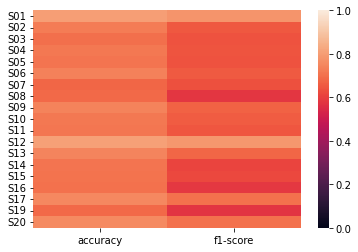

     class0 f1-score  class1 f1-score
S01         0.869919         0.578947
S02         0.832117         0.258065
S03         0.812721         0.231884
S04         0.827362         0.208955
S05         0.823529         0.200000
S06         0.843537         0.178571
S07         0.794326         0.275000
S08         0.810458         0.093750
S09         0.842444         0.246154
S10         0.823920         0.293333
S11         0.824818         0.200000
S12         0.874074         0.585366
S13         0.841379         0.323529
S14         0.823920         0.131148
S15         0.821192         0.156250
S16         0.822006         0.035088
S17         0.846442         0.369231
S19         0.810458         0.064516
S20         0.848276         0.371429


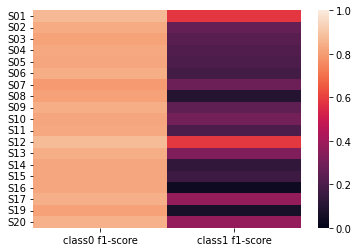

In [8]:
userfold_results_summary(participants_dictionary, participants)
userfold_classwise_results_summary(participants_dictionary, participants)


In [7]:
# channel_names=[i for i in range(input_dim[0])]
channel_names=["AFz","F3","F1","Fz","F2","F4","FC5","FC3","FC1","FCz","FC2",
               "FC4","FC6","C5","C3","C1","Cz","C2","C4","C6","CP5","CP3",
               "CP1","CPz","CP2","CP4","CP6","P3","P1","Pz","P2","P4"]

In [10]:
from sklearn.preprocessing import MinMaxScaler
import pickle

participant_grad={"AUC":[],"ROC":[],"STD":[]}

for i in range(len(participants)):

    g= pickle.load(
        open(f"{saved_dir}/Userfold-{participants[i]}-EEGNet-Grad_EEG-grad_all-e{n_epochs}.pkl", "rb") 
                    ) 
    
    participant_grad["AUC"].append(
        pd.DataFrame(
            Grad_AUC_with_grad(
                g, n_epochs, np.zeros(len(channel_names)), x_shape=0
            ).values()
        ).to_numpy().reshape(-1)
    )
    
    participant_grad["ROC"].append(
        pd.DataFrame(
            Grad_ROC_with_grad(
                g, n_epochs, np.zeros(len(channel_names)), x_shape=0
            ).values()
        ).to_numpy().reshape(-1)
    )
    
    participant_grad["STD"].append(
        pd.DataFrame(
            Grad_STD_with_grad(
                g, n_epochs, np.zeros(len(channel_names)), x_shape=0
            ).values()
        ).to_numpy().reshape(-1)
    )


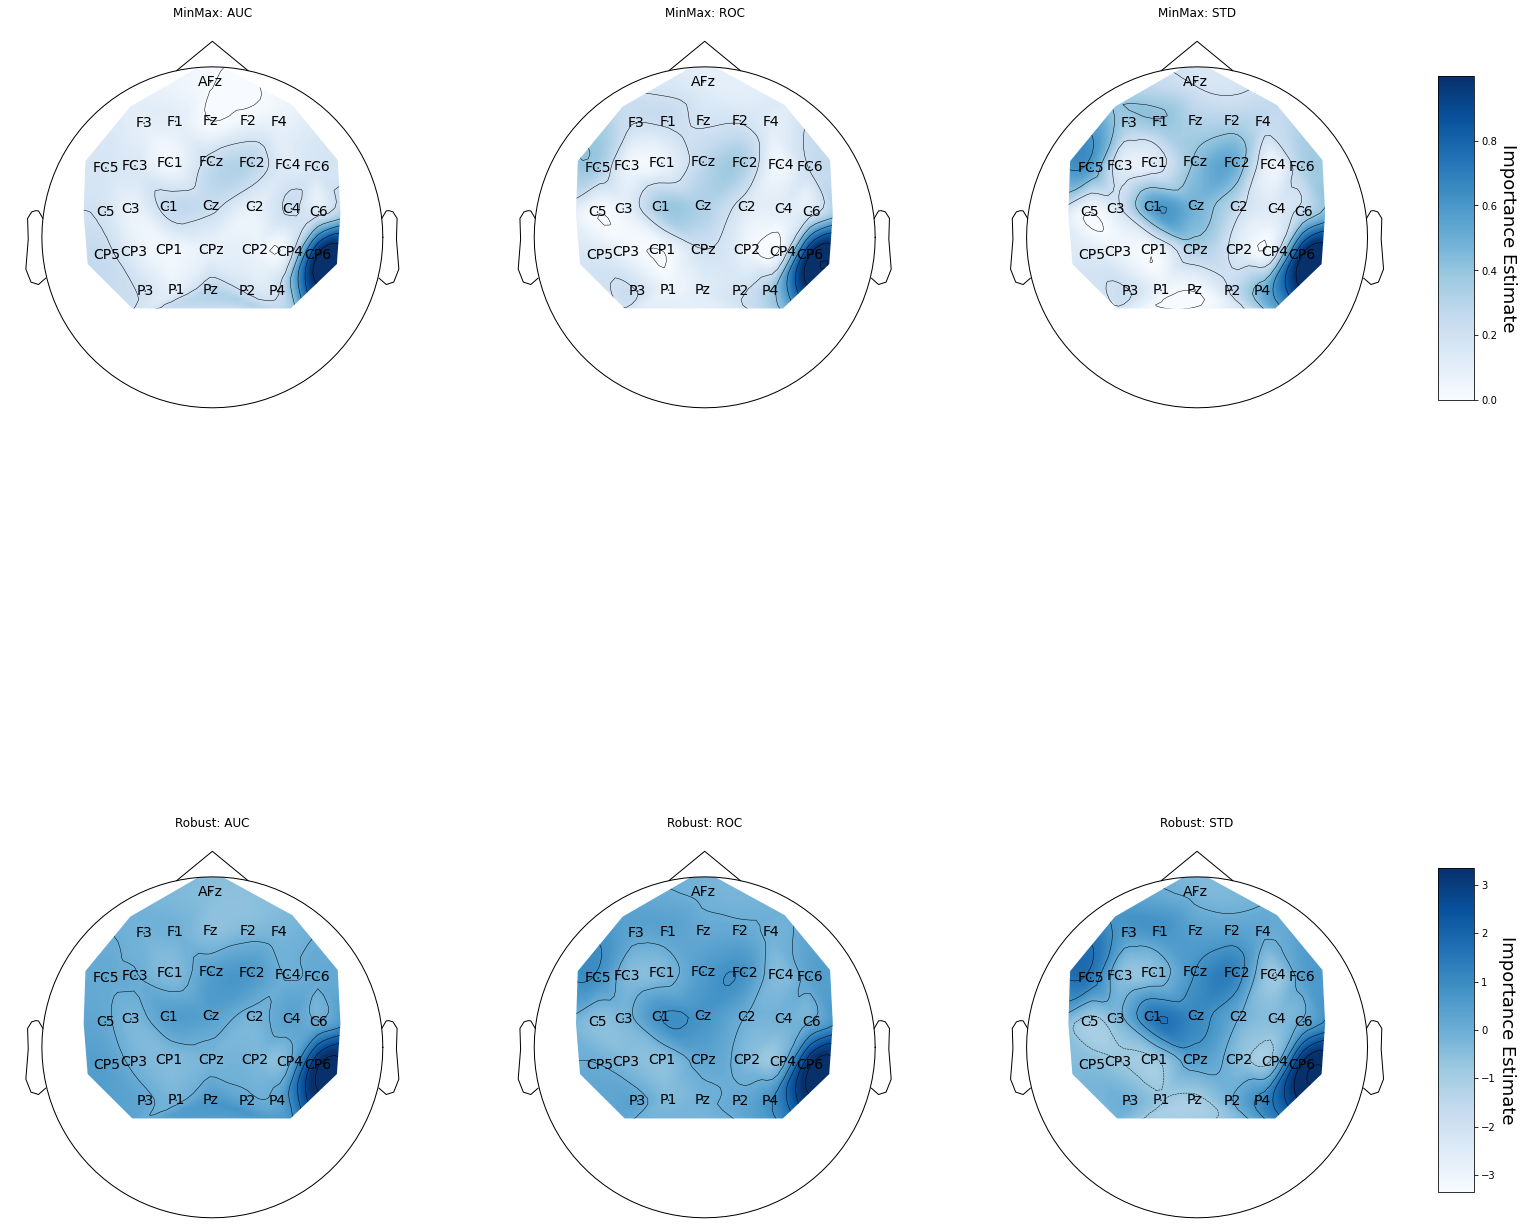

In [13]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
import matplotlib
import mne
info= mne.create_info(channel_names, sfreq=500, ch_types=32*["eeg"])
info.set_montage("standard_1020")

fig, ax= plt.subplots(2,3)
methods=["AUC", "ROC", "STD"]
for idx, i in enumerate(methods):
    scaler= MinMaxScaler()
    scaled_avg_grad= scaler.fit_transform(np.array(participant_grad[i]).mean(0).reshape(-1,1))
#     scaled_avg_grad= avg_grad[i].sum(1)

    minmax_im, _= mne.viz.plot_topomap(
        scaled_avg_grad.reshape(-1),
        info,
        ch_type= "eeg",
        sensors=True,
        names=channel_names,
        cmap="Blues",
        axes=ax[0][idx],
        show=False,
        extrapolate="local"
        #,vlim=(0,1)
    #     sphere=0.09
    )
    ax[0][idx].set_title(f"MinMax: {i}")
    
for idx, i in enumerate(methods):
    scaler= RobustScaler()
    scaled_avg_grad= scaler.fit_transform(np.array(participant_grad[i]).mean(0).reshape(-1,1))
#     scaled_avg_grad= avg_grad[i].sum(1)

    robust_im, _= mne.viz.plot_topomap(
        scaled_avg_grad.reshape(-1),
        info,
        ch_type= "eeg",
        sensors=True,
        names=channel_names,
        cmap="Blues",
        axes=ax[1][idx],
        show=False,
        extrapolate="local",
#         vlim=(0,None)
    #     sphere=0.09
    )
    ax[1][idx].set_title(f"Robust: {i}")
    
fig.set_figheight(25)
fig.set_figwidth(25)
# fig.add_axes(ax)
cbar_ax= fig.add_axes([.92,0.66, 0.02,0.18])
clb= fig.colorbar(minmax_im, cax=cbar_ax)
clb.set_label("Importance Estimate", rotation=270,labelpad=20, fontsize=18)

cbar_ax= fig.add_axes([.92,0.22, 0.02,0.18])
clb= fig.colorbar(robust_im, cax=cbar_ax)
clb.set_label("Importance Estimate", rotation=270,labelpad=20, fontsize=18)

for tt in plt.findobj(fig, matplotlib.text.Text):
    if tt.get_text() in channel_names:
        tt.set_fontsize(14)
# plt.tight_layout()